# The Netflix prize dataset
The dataset used here comes directly from Netflix. It consists of 4 text data files, each file contains over 20M rows, i.e. over 4K movies and 400K customers. All together there're 17K movies and 500K+ customers!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# loading a fraction of the data
nfd = pd.read_csv('../data/netflixdatacomb/combined_data_1.txt',header=None,names=['cust_id','rating'],usecols=[0,1])
nfd.head()

,cust_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


#### The structure of the data
* The data is structured in such a way:

| cust_id|rating|
|--------|------|
|movie 1| NaN|
| cid 1| rating|
|$\dots$| $\dots$|
|cid n|rating|
|movie 2| NaN|
|cid 1|rating|
|$\dots$|$\dots$|
|cid n|rating|
|movie 3|NaN|
|$\dots$|$\dots$|

* The `cust_id` column has a tuple of $(\text{movie}_{id},NaN)$ to indicate the following are reviews for movie $id$

In [3]:
# nfd.shape #(24058263, 2)
nfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   cust_id  object 
 1   rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [6]:
# this is the number of nulls in the rating column
Nof_movie = nfd.isnull().sum()['rating']

In [7]:
# the number of customers we have in the dataset,
# adjusted for the positions taken up by movie ids
Nof_cust = nfd['cust_id'].nunique()-Nof_movie

In [8]:
# the total number of ratings
Nof_rating = nfd['rating'].count()

In [9]:
# the number of ratings customer per rating
ratings = nfd.groupby('rating').agg(['count'])

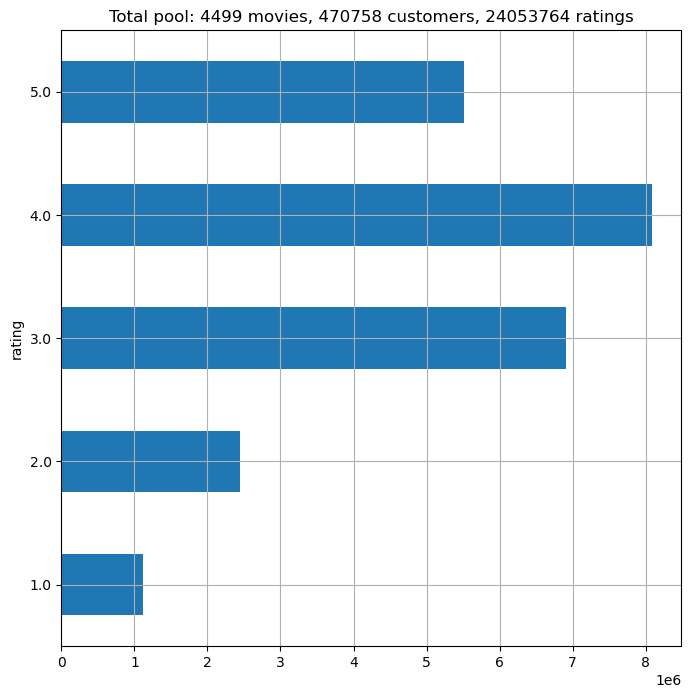

In [8]:
ax = ratings.plot(kind='barh',legend=False,figsize=(8,8))
plt.title(f'Total pool: {Nof_movie} movies, {Nof_cust} customers, {Nof_rating} ratings')
plt.grid()

In [14]:
# creating a dataframe for the movies and ratings count for each movie
Mdf = nfd[nfd['rating'].isnull()]
Mdf = Mdf.drop(columns='rating')

Mdf.reset_index(names='tin',inplace=True)

#getting the true number of ratings by subtracting the previous row from the next
Mdf['Nof_ratings']=Mdf['tin'].diff(-1).abs()-1

#the last entry needs to be entered manually
Mdf.iloc[-1,2] = nfd.shape[0]-Mdf.iloc[-1,0]-1
    
#dropping the unneeded columns
Mdf.drop(columns=['tin','cust_id'],inplace=True)

#creating the massive vector holding all the movie indexes
movie_np = np.array([])
for i,x in enumerate(Mdf.Nof_ratings.values):
    temp = np.repeat(i+1,x)
    movie_np = np.append(movie_np,values=temp)

In [16]:
# dropping the nulls
nfd.dropna(inplace=True)

# adding the movie_id column
nfd['movie_id'] = movie_np.astype('int')

In [17]:
# creating a summary dataset
dataset_movie_summary = nfd.groupby('movie_id')['rating'].agg(['count'])

# we will remove all the movies having low ratings counts, and customers who have given very few ratings will not be considered
# we will store all the movie_id indexes is a variable dataset_movie_summary.index and convert the datatype to int
drop_movie_indx = dataset_movie_summary[dataset_movie_summary['count']<np.ceil(dataset_movie_summary['count'].quantile(.7))].index

In [18]:
# creating another summary datatset for customers
ds_cust_summary = nfd.groupby('cust_id')['rating'].agg(['count'])


# removing all customers with few reviews
drop_cust_indx = ds_cust_summary[ds_cust_summary['count']<np.ceil(ds_cust_summary['count'].quantile(.7))].index

In [19]:
# dropping the found ids
nfd = nfd[~nfd['movie_id'].isin(drop_movie_indx)]
nfd = nfd[~nfd['cust_id'].isin(drop_cust_indx)]

In [29]:
import math
import seaborn as sns

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [26]:
# importing the movie metadata
mdf = pd.read_csv('../data/movie_titles.csv',encoding='ISO-8859-1', header=None, usecols=[0,1,2], names=['Movie_Id','Year','Name']) 
mdf.set_index('Movie_Id', inplace=True)    
mdf.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


## Creating the recommender system

In [31]:
# creating a reader class for the SVD algo
reader = Reader()

In [33]:
# will only use the top 100K rows for quick run-time
data = Dataset.load_from_df(nfd[:100000],reader)

In [35]:
# creating the svd instance
svd = SVD()
cross_validate(svd,data,measures=['MAE','RMSE'],cv=3)

{'test_mae': array([19.75729932, 19.77078998, 19.72268744]),
 'test_rmse': array([21.05929628, 21.0741812 , 21.03736377]),
 'fit_time': (1.7174744606018066, 1.7758119106292725, 1.7661402225494385),
 'test_time': (0.5789263248443604, 0.32783079147338867, 0.30811524391174316)}

## Now we can recommend movies!
Take user '712664'<br>
We will try to recommend some movies for him based on his past ratings:

In [84]:
freq = pd.crosstab(nfd['cust_id'],nfd.rating)
df712664=freq.loc['712664',:].values

In [94]:
df = df712664*100/np.sum(df712664)
print(f' The id 712664 has {df[0]:.1f}% one* reviews, {df[1]:.1f}% two*, {df[2]:.1f}% three*, {df[3]:.1f}% four* and {df[4]:.1f}% five*')

 The id 712664 has 9.0% one* reviews, 11.7% two*, 18.3% three*, 38.0% four* and 23.0% five*


## Now we will create a df for id 712664

In [97]:
ds712664 = nfd[ (nfd['cust_id']==712664) & (nfd['rating']==5)]

In [99]:
# first we will make a shallow copy of the movie_titles.csv file so that we can change 
# the values in the copies dataset, not in the actual dataset

mt712664 = mdf.copy()
mt712664.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [101]:
# resetting the index
mt712664 = mt712664.reset_index()
mt712664 = mt712664[~mt712664.Movie_Id.isin(drop_movie_indx.to_list())]

In [103]:
# applying the SVD algorithm
mt712664['estimate_score'] = mt712664['Movie_Id'].apply(lambda x:svd.predict(712664,x).est)
mt712664 = mt712664.drop('Movie_Id',axis=1)

In [105]:
mt712664 = mt712664.sort_values('estimate_score')
mt712664.head()

,Year,Name,estimate_score
2,1997.0,Character,5
12889,1976.0,Carrie,5
12890,2003.0,24: Season 3,5
12891,1995.0,Smoke,5
12892,2004.0,Driving Miss Wealthy,5
